<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/03_TextImage/captum_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Captum Interpretability Library Example using Titanic Data

Reference: https://www.captum.ai/tutorials/Titanic_Basic_Interpret

In [4]:
!pip install captum

     |████████████████████████████████| 532kB 8.8MB/s 


In [0]:
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [7]:
# convert categorical features to on-hot

df = pd.concat([df,
                pd.get_dummies(df['sex']),
                pd.get_dummies(df['embarked'], prefix='embark'),
                pd.get_dummies(df['pclass'], prefix='class')],
              axis=1)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1,0,0,0,1,1,0,0
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0


In [8]:
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1,0,0,0,1,1,0,0
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0


In [9]:
df.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest',
         'sex', 'embarked', 'pclass'],
        axis=1, inplace=True)
df.head()

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.00,0,0,211.3375,1,0,0,0,1,1,0,0
1,1,0.92,1,2,151.5500,0,1,0,0,1,1,0,0
2,0,2.00,1,2,151.5500,1,0,0,0,1,1,0,0
3,0,30.00,1,2,151.5500,0,1,0,0,1,1,0,0
4,0,25.00,1,2,151.5500,1,0,0,0,1,1,0,0


In [10]:
np.random.seed(42)
torch.manual_seed(42)

In [0]:
target = 'survived'
y = df.loc[:, target].values
X = df.loc[:, df.columns != target].values
feature_names = df.columns[df.columns != target]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [0]:
class TitanicSimpleNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(12, 12)
    self.act1 = nn.Sigmoid()
    self.linear2 = nn.Linear(12, 8)
    self.act2 = nn.Sigmoid()
    self.linear3 = nn.Linear(8, 2)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)
    return self.softmax(x)

In [14]:
criterion = nn.CrossEntropyLoss()
num_epochs = 200

net = TitanicSimpleNNModel()
optimizer = optim.Adam(net.parameters(), lr=.1)
input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
label_tensor = torch.from_numpy(y_train)

for epoch in range(num_epochs):
  output = net(input_tensor)
  loss = criterion(output, label_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if epoch % 20 == 0:
    print(f'Epoch {epoch+1}/{num_epochs} => Loss: {loss.item():.2f}')

Epoch 1/200 => Loss: 0.71
Epoch 21/200 => Loss: 0.58
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.49
Epoch 141/200 => Loss: 0.49
Epoch 161/200 => Loss: 0.48
Epoch 181/200 => Loss: 0.48


In [15]:
pred_probs = net(input_tensor).detach().numpy()
preds = pred_probs.argmax(axis=1)
print(f'Train Accuracy: {accuracy_score(y_train, preds)}')

Train Accuracy: 0.8296943231441049


In [16]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
pred_probs = net(test_input_tensor).detach().numpy()
preds = pred_probs.argmax(axis=1)
print(f'Test Accuracy: {accuracy_score(y_test, preds)}')

Test Accuracy: 0.7811704834605598


### Integrated Gradients

A Feature Attribution technique. Takes tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the given examples.

https://arxiv.org/pdf/1703.01365.pdf

In [0]:
ig = IntegratedGradients(net)

In [0]:
test_input_tensor.requires_grad_() # require gradient

# get input attributions for target = 1 (survival) using Integrated Gradients
# this approximates the integral of gradients along the path from a baseline
# input to the given input.
attr, delta = ig.attribute(test_input_tensor, target=1,
                           return_convergence_delta=True)
attr = attr.detach().numpy()

In [19]:
attr

array([[-3.3813727e-03, -0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00, -1.8280961e-03],
       [-7.1008732e-03, -2.1657282e-03,  1.4228747e-03, ...,
         0.0000000e+00,  0.0000000e+00, -7.9069873e-03],
       [-3.2159707e-03, -0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00, -2.0720586e-03],
       ...,
       [-1.3127583e-02, -0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.0084441e-02, -0.0000000e+00],
       [-1.9616147e+00, -0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00, -2.3396571e+00],
       [-2.0044845e-01, -6.0034860e-02,  0.0000000e+00, ...,
         0.0000000e+00,  1.7427096e-01, -0.0000000e+00]], dtype=float32)

In [20]:
# attributions for each row, get their mean
attr.mean(axis=0)

array([-0.26972222, -0.04855341,  0.01417277,  0.32402664,  0.46169707,
       -0.21598594,  0.06448521,  0.01002057, -0.0396778 ,  0.16264492,
        0.04956455, -0.23354223], dtype=float32)

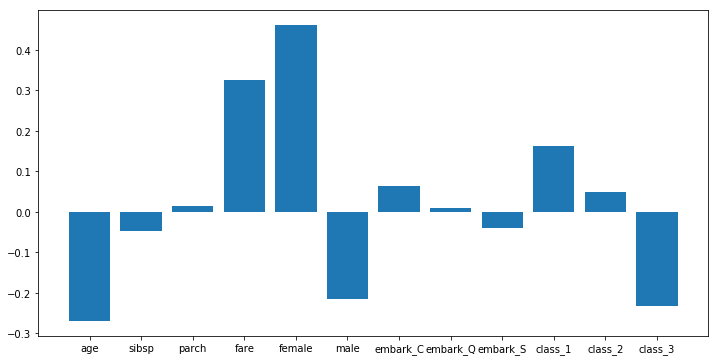

In [21]:
x_pos = (np.arange(len(feature_names)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x_pos, attr.mean(axis=0))
ax.set_xticks(x_pos)
ax.set_xticklabels(list(feature_names))
plt.show()

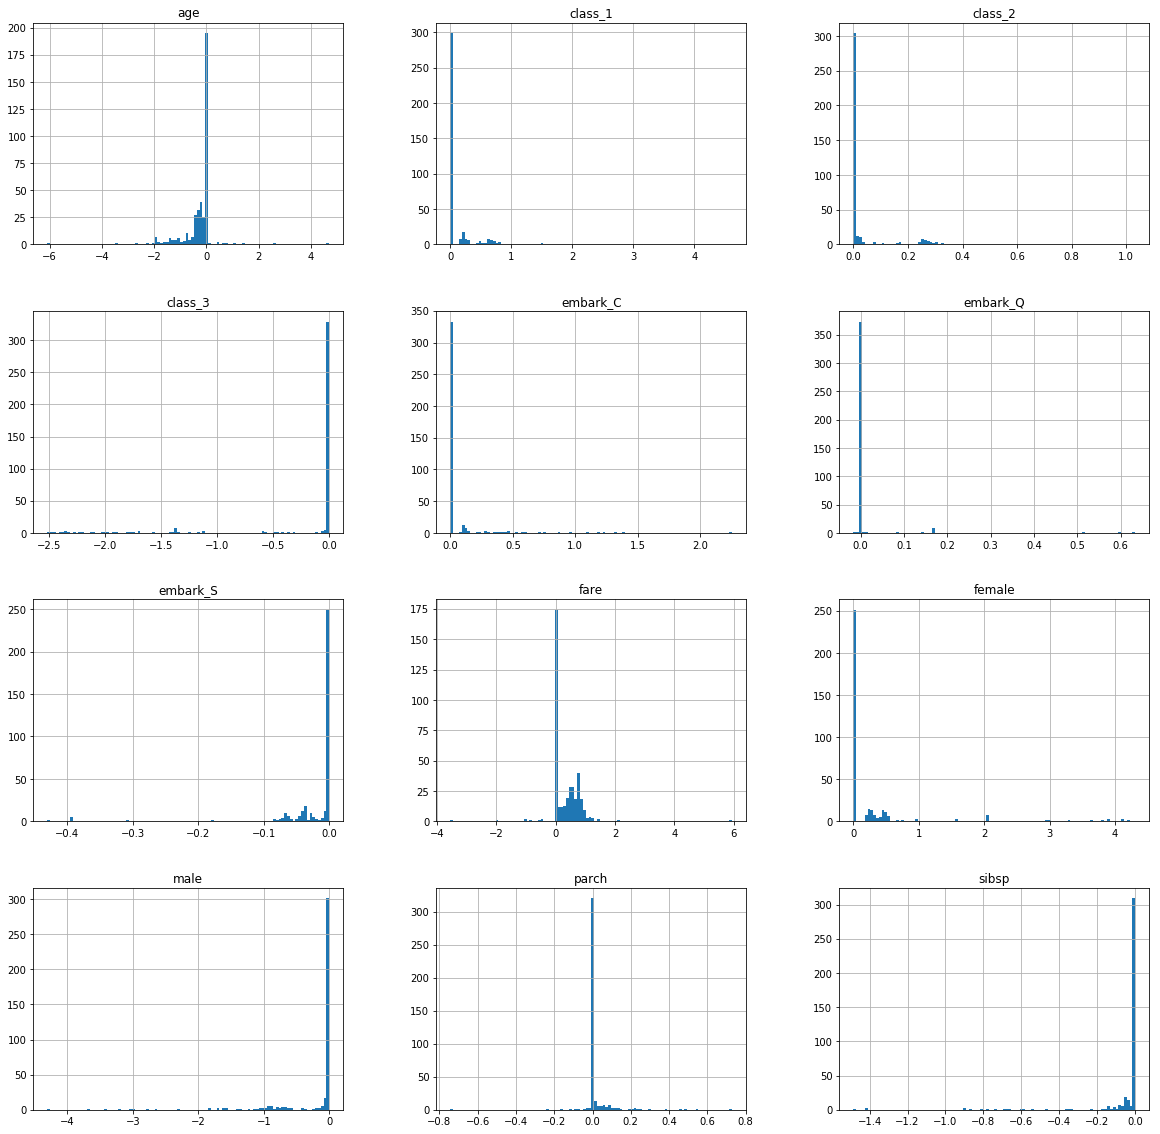

In [22]:
# visualise distributions of the attributes
# because these are generated from test set, so the attribution may not reflect
# actual dataset distribution
attr_df = pd.DataFrame(attr, columns=feature_names)
attr_df.hist(figsize=(20, 20), bins=100)
plt.show()

In [0]:
# bucket examples by value and plot average attribution.
# size of dot is proportion to number of samples of a given value bucket.

def plot_binned_attribution(values, attrs, name, ax):
  bin_means, bin_edges, _ = stats.binned_statistic(values, 
                                                   attrs,
                                                   statistic='mean',
                                                   bins=6)
  bin_count, _, _ = stats.binned_statistic(values,
                                           attrs,
                                           statistic='count',
                                           bins=6)

  bin_width = (bin_edges[1] - bin_edges[0])
  bin_centers = bin_edges[1:] - bin_width/2
  ax.scatter(bin_centers, bin_means, s=bin_count)
  ax.set_title(name)

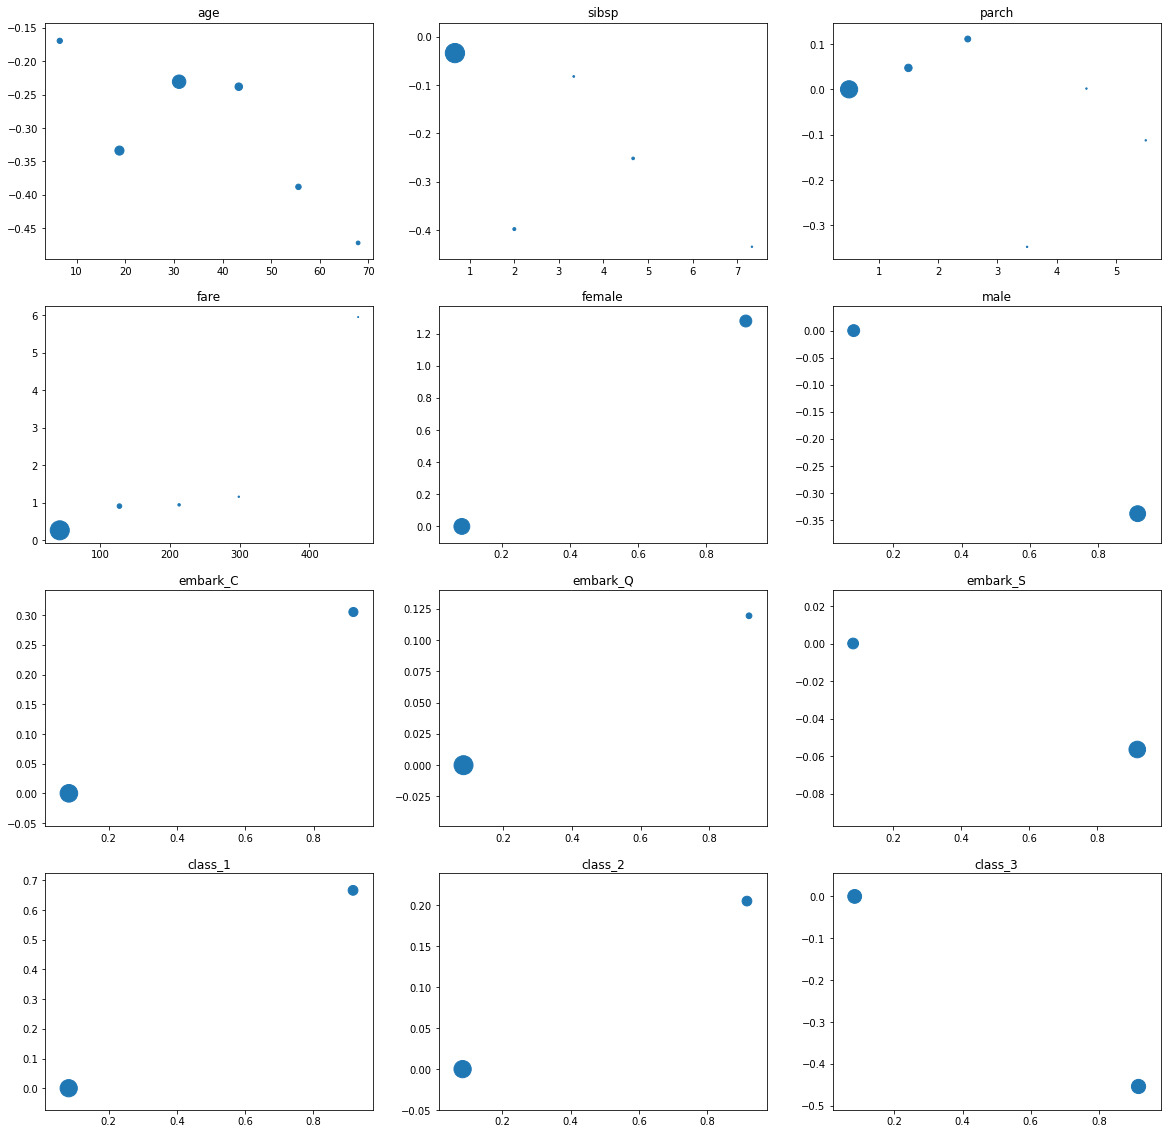

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i in range(len(feature_names)):
  plot_binned_attribution(X_test[:, i], attr[:, i], feature_names[i], axes[i])
plt.show()

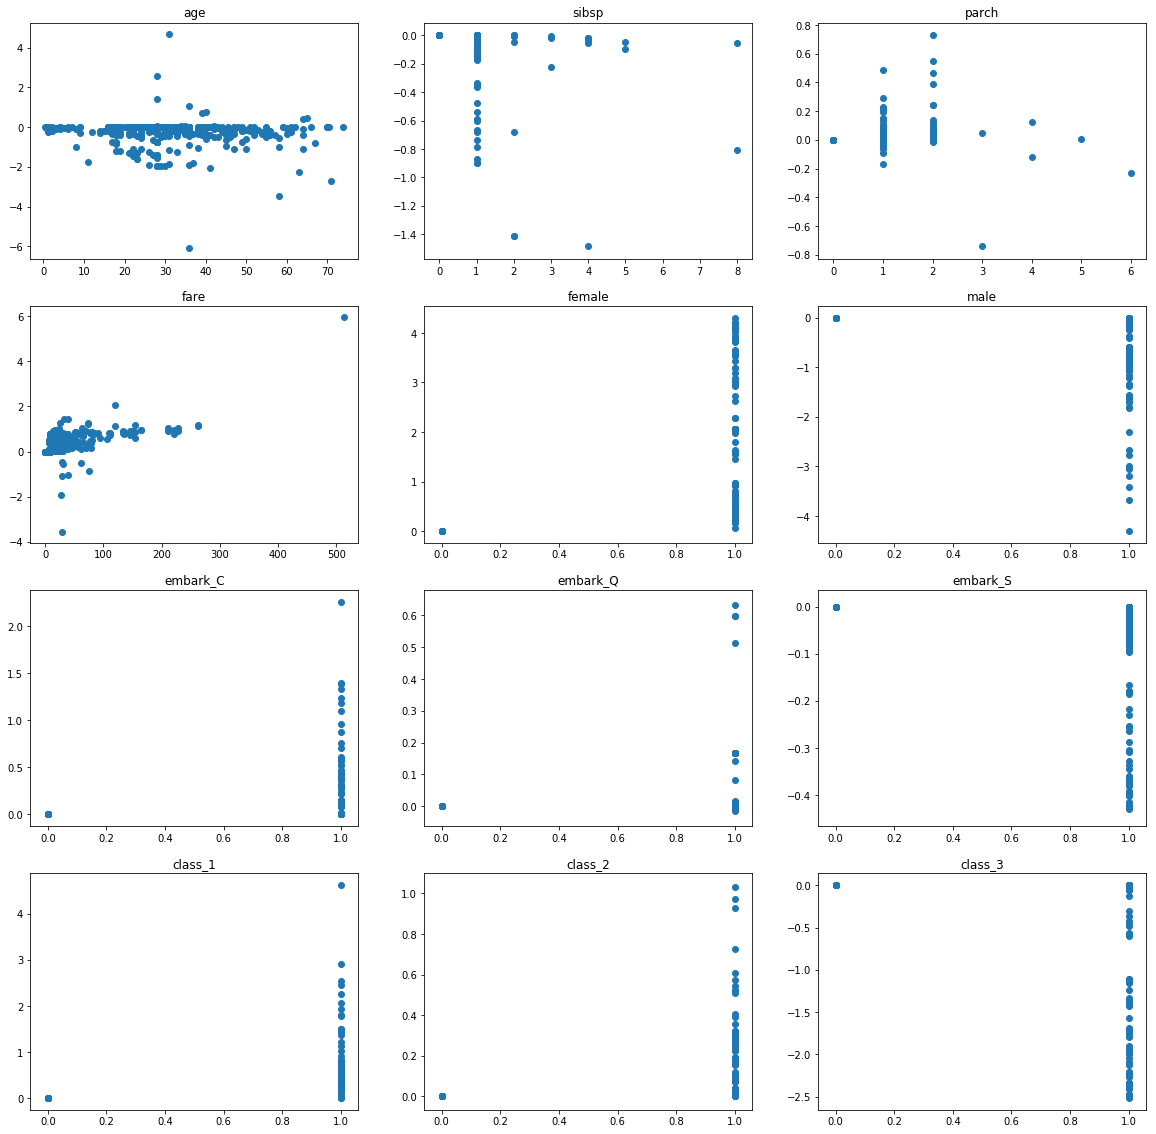

In [25]:
# scatter plot of values and attr

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i in range(len(feature_names)):
  axes[i].scatter(X_test[:, i], attr[:, i])
  axes[i].set_title(feature_names[i])
plt.show()

### Layer Attributions

Understand the importance (conductance) of the neurons in a particular neural network layer.

https://arxiv.org/abs/1805.12233

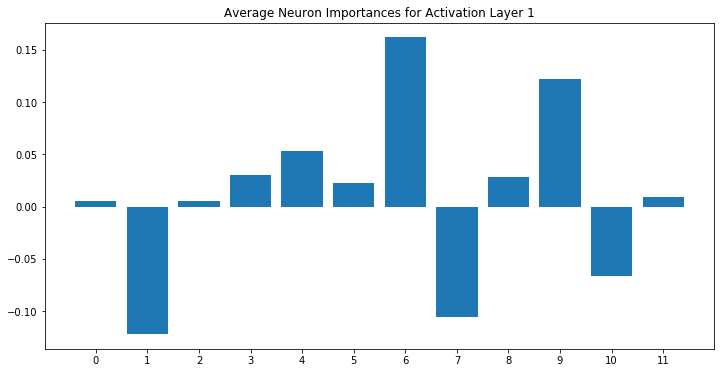

In [26]:
lc_act1 = LayerConductance(net, net.act1)
lc_vals = lc_act1.attribute(test_input_tensor, target=1)
lc_vals = lc_vals.detach().numpy()

fig, ax = plt.subplots(figsize=(12, 6))

neuron_indices = range(12)
ax.bar(neuron_indices, lc_vals.mean(axis=0))
ax.set_xticks(neuron_indices)
ax.set_title('Average Neuron Importances for Activation Layer 1')
plt.show()

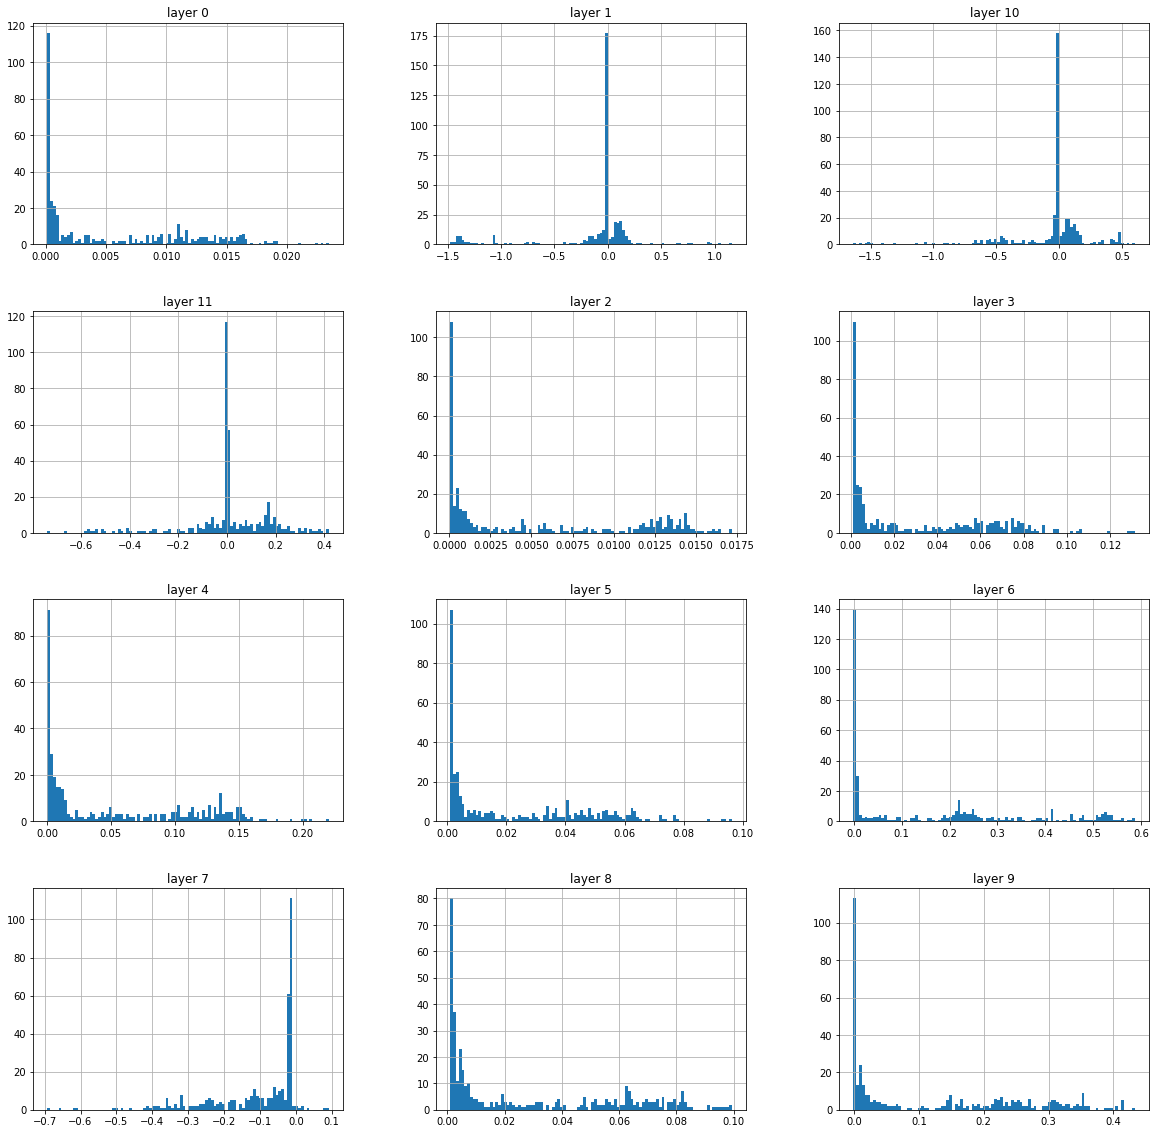

In [27]:
# visualise distributions of the neuron importances
colnames = [f'layer {i}' for i in range(lc_vals.shape[1])]
lc_vals_df = pd.DataFrame(lc_vals, columns=colnames)
lc_vals_df.hist(figsize=(20, 20), bins=100)
plt.show()

In [28]:
# stats
lc_vals_df.describe()

,layer 0,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,0.005704,-0.121775,0.005251,0.030472,0.053563,0.022702,0.161741,-0.105858,0.028441,0.122334,-0.066376,0.009180
std,0.006181,0.441644,0.005693,0.032249,0.058009,0.023881,0.184899,0.130116,0.030234,0.132711,0.327309,0.172465
min,0.000141,-1.475290,0.000071,0.001180,0.000182,0.001104,-0.001091,-0.692546,0.000978,-0.001080,-1.636863,-0.739174
25%,0.000285,-0.052427,0.000227,0.002064,0.002816,0.001855,0.000448,-0.166697,0.002079,0.002368,-0.028423,-0.001077
50%,0.002130,-0.006272,0.001710,0.012913,0.019848,0.009934,0.067897,-0.040486,0.010243,0.044821,-0.005427,0.002237
75%,0.010978,0.046158,0.011825,0.059318,0.109201,0.042540,0.263566,-0.015014,0.058079,0.238159,0.058885,0.093233
max,0.023501,1.163480,0.017187,0.131576,0.220780,0.096353,0.587450,0.092558,0.099439,0.433394,0.601414,0.419969


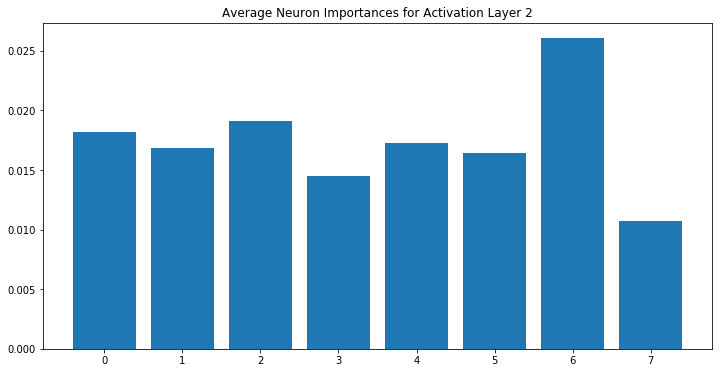

In [29]:
# let's see layer 2
lc_act2 = LayerConductance(net, net.act2)
lc_vals = lc_act2.attribute(test_input_tensor, target=1)
lc_vals = lc_vals.detach().numpy()

fig, ax = plt.subplots(figsize=(12, 6))
neuron_indices = range(8)
ax.bar(neuron_indices, lc_vals.mean(axis=0))
ax.set_xticks(neuron_indices)
ax.set_title('Average Neuron Importances for Activation Layer 2')
plt.show()

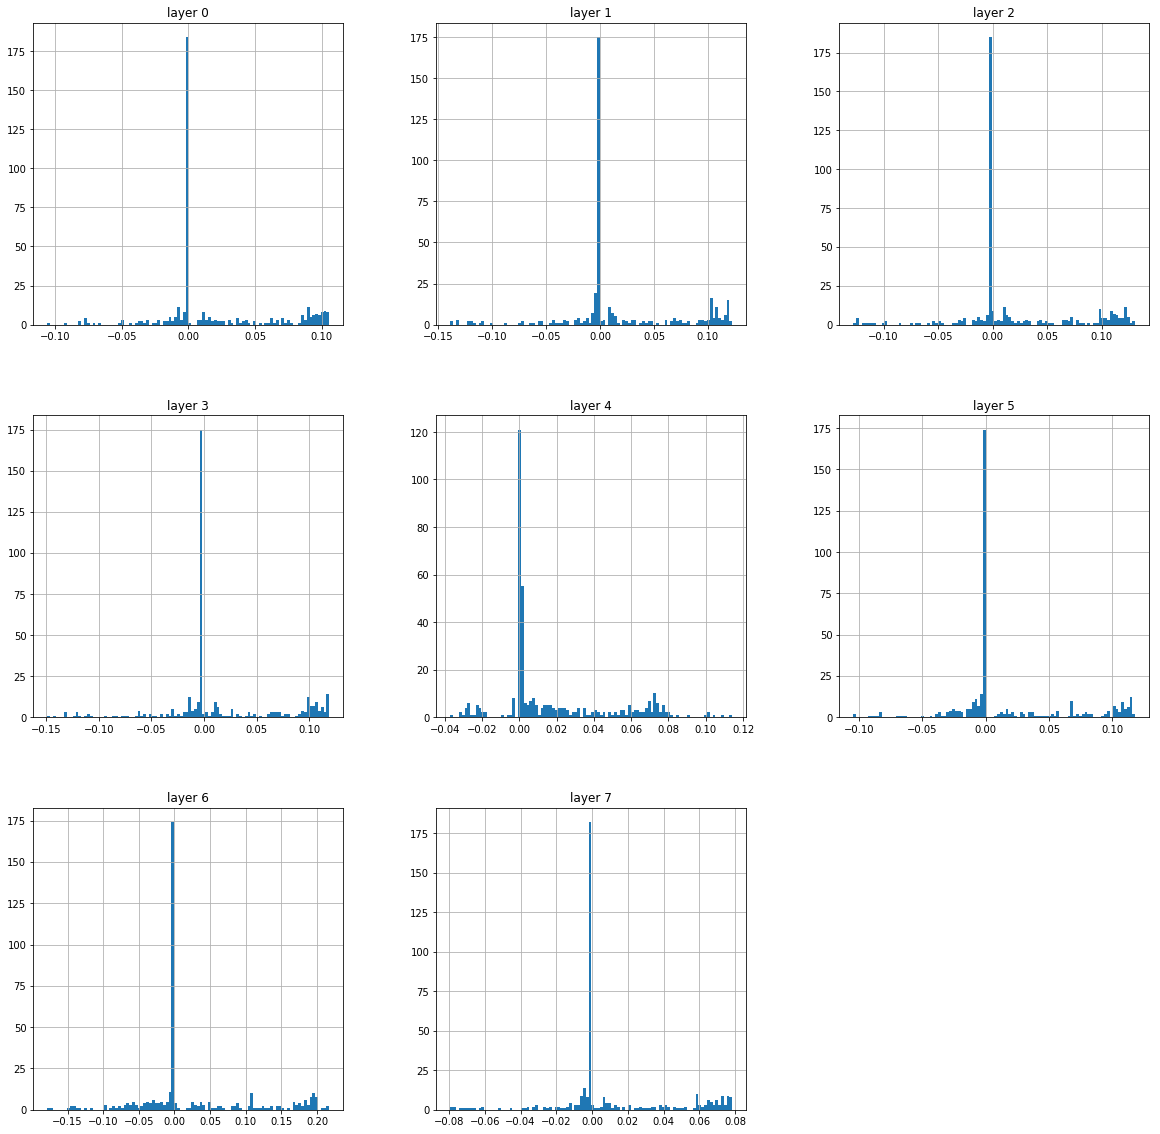

In [30]:
# visualise distributions of the neuron importances
colnames = [f'layer {i}' for i in range(lc_vals.shape[1])]
lc_vals_df = pd.DataFrame(lc_vals, columns=colnames)
lc_vals_df.hist(figsize=(20, 20), bins=100)
plt.show()

In [31]:
# stats
lc_vals_df.describe()

,layer 0,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,0.018160,0.016853,0.019085,0.014540,0.017267,0.016406,0.026070,0.010739
std,0.043427,0.054166,0.053573,0.054544,0.030247,0.046596,0.081182,0.033030
min,-0.105726,-0.138915,-0.127677,-0.149032,-0.036893,-0.104617,-0.178256,-0.079211
25%,-0.001228,-0.002563,-0.002138,-0.002771,0.000260,-0.002092,-0.002855,-0.001556
50%,-0.000730,-0.002063,-0.001606,-0.002329,0.001689,-0.001651,-0.002054,-0.001245
75%,0.039230,0.040714,0.044307,0.039492,0.031262,0.033986,0.049211,0.024642
max,0.105516,0.122612,0.130716,0.119234,0.114196,0.118207,0.217050,0.078296


### Neuron Attributions

Neuron Conductance divides the neuron's total conductance value into the contribution from each individual input feature.

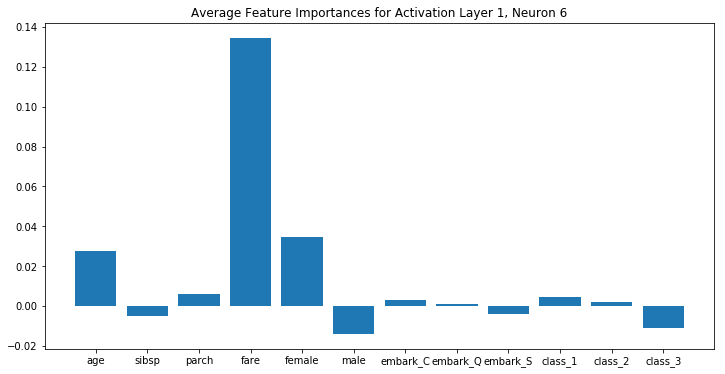

In [32]:
# In layer 1, neuron 6 has highest average conductance,
# cross reference with feature

nc_act1 = NeuronConductance(net, net.act1)

nc_vals6 = nc_act1.attribute(test_input_tensor, neuron_index=6, target=1)\
  .detach().numpy()

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x_pos, nc_vals6.mean(axis=0))
ax.set_xticks(x_pos)
ax.set_xticklabels(list(feature_names))
ax.set_title('Average Feature Importances for Activation Layer 1, Neuron 6')
plt.show()

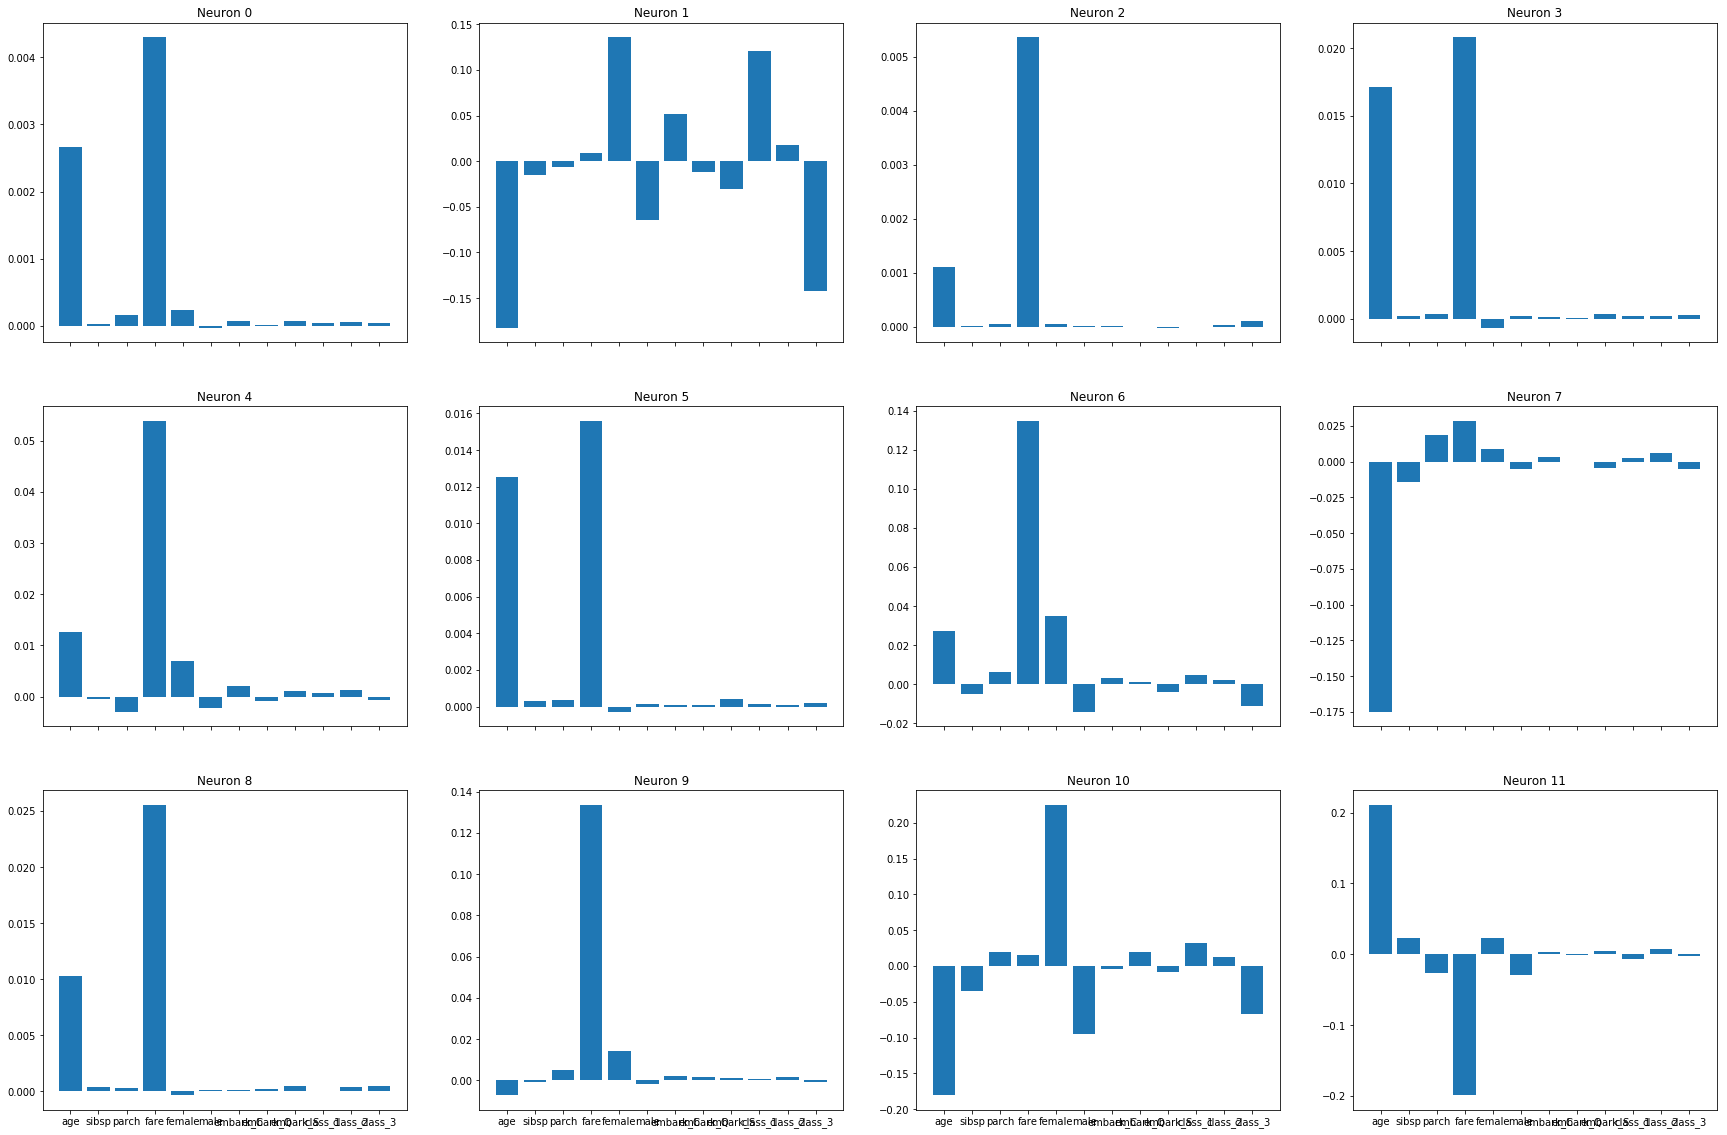

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20), sharex=True)
axes = axes.flatten()

for i in range(12):
  nc_vals = nc_act1.attribute(test_input_tensor, neuron_index=i, target=1)\
    .detach().numpy()

  ax = axes[i]
  ax.bar(x_pos, nc_vals.mean(axis=0))
  ax.set_xticks(x_pos)
  ax.set_xticklabels(list(feature_names))
  ax.set_title(f'Neuron {i}')

plt.show()